<a href="https://colab.research.google.com/github/leeaain2027/AIFFEL_quest_eng/blob/main/260206_CV_camera_sticker_project_leeaain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 고양이 수염 스티커 만들기
1. 얼굴 검출 & 랜드마크 검출하기  
2. 스티커 적용 위치 확인하기  
- 고양이 수염이 적용 될 위치를 landmark를 사용해서 계산해주기

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 현재 작업 디렉토리 하위에 폴더 만들기
!mkdir -p ./models
!mkdir -p ./images

# 내 구글 드라이브에서 필요한 이미지 복사해오기
# 고양이 수염 이미지
!cp drive/MyDrive/Aiffel/week6/cat-whiskers.png ./images
# 얼굴 사진
!cp drive/MyDrive/Aiffel/week6/korean_woman.png ./images
# 얼굴 랜드마크 참고용 이미지
!cp drive/MyDrive/Aiffel/week6/face_landmark.png ./images

Mounted at /content/drive


In [ ]:
import os # 환경 변수, 디렉터리, 파일 등 OS 자원을 제어하는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍
import matplotlib.pyplot as plt # 도식화
import numpy as np # 다차원 배열 처리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 가능한 c++ 로 개발된 고성능의 라이브러리
print("🌫🛸")

🌫🛸


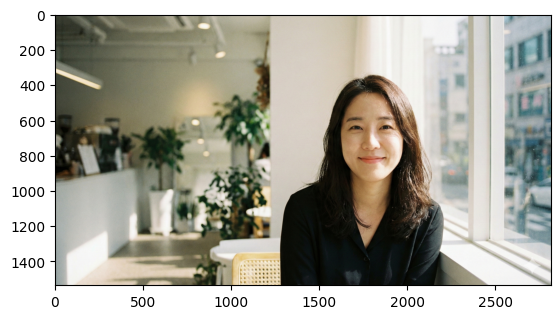

In [ ]:
# 얼굴 사진 준비
image_path = os.path.join('./images/korean_woman.png') # 본인 이미지가 있는 경로를 가지고 온다.

# OpenCV로 이미지 불러오기 (BGR 순서)
img_bgr = cv2.imread(image_path)
# bgr -> rgb로 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 출력용 이미지 따로 보관
img_show = img_rgb.copy()

# 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.imshow(img_rgb)

# 이미지 출력 (실제 출력)
plt.show()

### 얼굴 검출
dlib의  hog detector로 기본 얼굴 감지

In [ ]:
detector_hog = dlib.get_frontal_face_detector()
detector_hog

hog detector로 얼굴의 boudning box 추출  
한 이미지에 얼굴이 여러개 있을 수 있으므로 list로 반환됨.

In [ ]:
# image pyramid값을 1로 주고 업샘플링
dlib_rects = detector_hog(img_rgb, 1)
dlib_rects

rectangles[[(1616, 547) (2001, 932)]]

추출한 얼굴의 bounding box 좌표값들을 l,t,r,b 변수에 쪼개서 할당하고  
해당 값들을 이용해서 copy해두었던 원본 이미지 위에 사각형 박스를 그림.

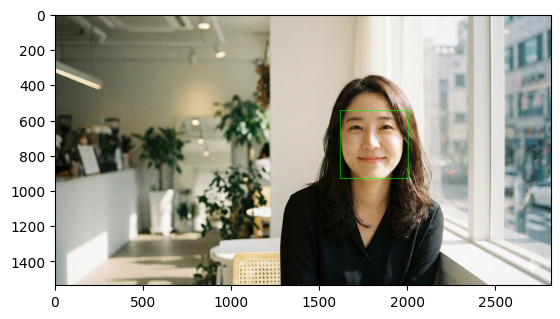

In [ ]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    # 'img_show'위에 사각형 박스 그리기
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_show)
plt.show()

얼굴이 2개 이상이면

rectangles[[(1632, 455) (1953, 776)], [(990, 491) (1311, 812)]]


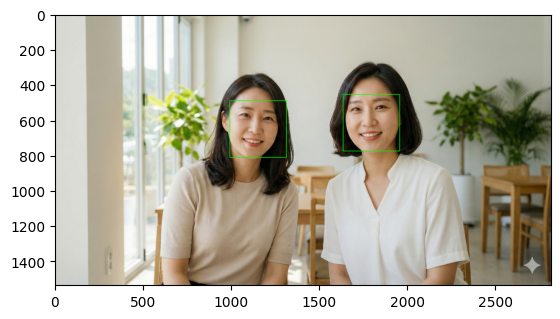

In [ ]:
!cp drive/MyDrive/Aiffel/week6/two_women.png ./images

two_women = cv2.imread('./images/two_women.png')
two_women_rgb = cv2.cvtColor(two_women, cv2.COLOR_BGR2RGB)
dlib_rects2 = detector_hog(two_women_rgb, 1)
print(dlib_rects2)

for dlib_rect in dlib_rects2: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
    cv2.rectangle(two_women_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(two_women_rgb)
plt.show()


### 얼굴 랜드마크 찾기
face landmark같은 '객체 내부의 점'을 찾는 기술 - object keypoint estimation  
탑다운 방식과 바텀업 방식중 탑다운 방식 시도


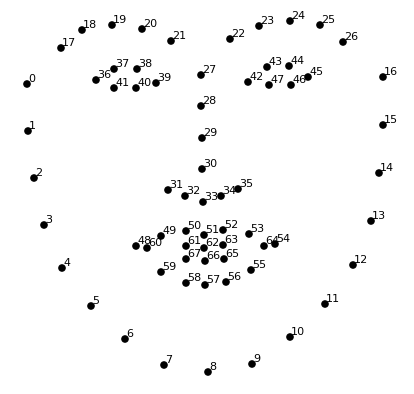

In [ ]:
# Dlib이 가지고 있는 얼굴 랜드마크 위치 68개 확인
from IPython.display import Image

Image(filename='./images/face_landmark.png', width=400)

Dlib의 landmark 사전학습 모델을 사용하기 위해 가중치 파일을 다운로드하고 압축 해제

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 ./models
!bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

--2026-02-07 00:21:55--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2026-02-07 00:21:55--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  40.8MB/s    in 1.5s    

2026-02-07 00:21:57 (40.8 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



Dlib의 landmark 사전학습 모델 불러옴

In [ ]:
model_path = './models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
    # 이 모델은 RGB이미지와 dlib.rectangle를 입력 받고
    # dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치, 이미지 상의 객체의 위치를 나타냄

print(landmark_predictor)

In [ ]:
list_landmarks = []

# face landmark 찾아내서 좌표 저장해두기
# dlib_rects -> rectangles[[(1616, 547) (2001, 932)]]
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)  # [(1616, 547) (2001, 932)]
        # 각 구성요소 위치, 이미지 상의 객체 위치 반환
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks))
print(len(list_landmarks[0]))
print(list_landmarks[:])

1
68
[[(1619, 678), (1620, 725), (1627, 770), (1637, 816), (1657, 857), (1687, 892), (1721, 922), (1762, 943), (1806, 946), (1851, 936), (1891, 909), (1923, 875), (1948, 838), (1964, 798), (1969, 753), (1969, 707), (1961, 660), (1641, 624), (1659, 597), (1690, 585), (1723, 586), (1755, 598), (1817, 597), (1846, 583), (1879, 580), (1911, 589), (1933, 611), (1788, 641), (1789, 676), (1790, 710), (1791, 745), (1753, 766), (1772, 772), (1792, 777), (1811, 770), (1829, 765), (1680, 649), (1699, 638), (1719, 638), (1739, 654), (1719, 653), (1698, 652), (1839, 652), (1859, 637), (1880, 635), (1900, 644), (1882, 649), (1861, 650), (1718, 818), (1747, 809), (1773, 802), (1794, 807), (1813, 802), (1840, 809), (1869, 816), (1840, 834), (1816, 842), (1794, 845), (1772, 843), (1748, 836), (1727, 818), (1773, 822), (1794, 824), (1814, 822), (1858, 817), (1814, 820), (1794, 822), (1772, 821)]]


list_landmarks의 0번째 배열에
68개의 랜드마크들이 튜플 형태로 담겨있다.  

이번에는 얼굴이 하나라서 1개의 배열만 담겼지만, 얼굴이 여러개라면 list_landmarks는 여러개의 배열을 가지게 된다.

여기서 points안에 들어있는 값들과
parts()를 하면 어떻게 되는건지 궁금해서 확인해보았다.

In [ ]:
# 각 구성요소 위치, 이미지 상의 객체 위치 반환
points = landmark_predictor(img_rgb, dlib_rect)  # [(1616, 547) (2001, 932)]

for point in points.parts():
    print(point)


(1619, 678)
(1620, 725)
(1627, 770)
(1637, 816)
(1657, 857)
(1687, 892)
(1721, 922)
(1762, 943)
(1806, 946)
(1851, 936)
(1891, 909)
(1923, 875)
(1948, 838)
(1964, 798)
(1969, 753)
(1969, 707)
(1961, 660)
(1641, 624)
(1659, 597)
(1690, 585)
(1723, 586)
(1755, 598)
(1817, 597)
(1846, 583)
(1879, 580)
(1911, 589)
(1933, 611)
(1788, 641)
(1789, 676)
(1790, 710)
(1791, 745)
(1753, 766)
(1772, 772)
(1792, 777)
(1811, 770)
(1829, 765)
(1680, 649)
(1699, 638)
(1719, 638)
(1739, 654)
(1719, 653)
(1698, 652)
(1839, 652)
(1859, 637)
(1880, 635)
(1900, 644)
(1882, 649)
(1861, 650)
(1718, 818)
(1747, 809)
(1773, 802)
(1794, 807)
(1813, 802)
(1840, 809)
(1869, 816)
(1840, 834)
(1816, 842)
(1794, 845)
(1772, 843)
(1748, 836)
(1727, 818)
(1773, 822)
(1794, 824)
(1814, 822)
(1858, 817)
(1814, 820)
(1794, 822)
(1772, 821)


얼굴이 하나 이상일 때도 시도해보기

In [ ]:
# 얼굴이 여러개일때

이미지 위에 랜드마크 출력해보기

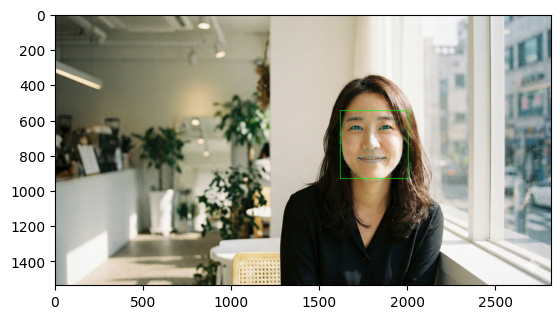

In [ ]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 10, (0, 255, 255), 1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 n이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수: 테두리 두께 값. 양수이면 속이 빈 원, 음수이면 속이 꽉 찬 원

# 이미지를 준비
plt.imshow(img_show)

# 이미지를 출력
plt.show()

### 스티커 적용하기  
랜드마크 기준으로 '코 아래 얼굴중앙'에 스티커 씌우기.  
얼굴 위치, 카메라 거리에 따라 픽셀 x가 다르기 때문에 비율로 계산해야 함.

스티커의 맨 윗부분이 코 아래(33번 점)에 닿게 되기 때문에

In [ ]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역 바운딩 박스 위치값
# → rectangles[[(345, 98) (531, 284)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
# → [[(368, 153), (368, 174), (371, 195), (376, 215), (382, 235), (391, 252), (404, 266), (420, 277), (441, 279), (461, 276), (480, 266), (495, 252), (508, 235), (516, 216), (520, 195), (523, 173), (524, 151), (377, 131), (386, 119), (399, 116), (413, 118), (425, 124), (454, 121), (466, 114), (481, 112), (494, 114), (503, 127), (439, 143), (438, 156), (438, 169), (437, 182), (423, 197), (431, 199), (438, 200), (446, 199), (454, 197), (391, 147), (399, 142), (409, 143), (416, 149), (408, 150), (399, 150), (464, 147), (472, 141), (482, 141), (489, 145), (482, 149), (473, 149), (411, 227), (421, 222), (432, 218), (439, 220), (446, 218), (458, 222), (471, 227), (458, 234), (446, 238), (438, 238), (431, 238), (420, 235), (415, 227), (432, 227), (439, 228), (447, 227), (466, 227), (446, 228), (438, 229), (431, 228)]]

# 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # dlib_rect: 얼굴 탐지기(detector)가 사진에서 찾은 "얼굴 박스"
    print(landmark)
    print (f'코 아래 중심점: {landmark[33]}') # 코 아래부분의 index는 33
    x = landmark[33][0] # 이미지에서 코 부위의 x값

    # 이미지에서 코 아래의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2
    # 스티커의 맨 윗부분이 코 아래(33번 점)에 닿게 되기 때문에
    y = landmark[33][1] - dlib_rect.height()//2
    # y = landmark[33][1]

    # 얼굴 영역 가로를 차지하는 픽셀의 수
    w = h = dlib_rect.width()
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

[(1619, 678), (1620, 725), (1627, 770), (1637, 816), (1657, 857), (1687, 892), (1721, 922), (1762, 943), (1806, 946), (1851, 936), (1891, 909), (1923, 875), (1948, 838), (1964, 798), (1969, 753), (1969, 707), (1961, 660), (1641, 624), (1659, 597), (1690, 585), (1723, 586), (1755, 598), (1817, 597), (1846, 583), (1879, 580), (1911, 589), (1933, 611), (1788, 641), (1789, 676), (1790, 710), (1791, 745), (1753, 766), (1772, 772), (1792, 777), (1811, 770), (1829, 765), (1680, 649), (1699, 638), (1719, 638), (1739, 654), (1719, 653), (1698, 652), (1839, 652), (1859, 637), (1880, 635), (1900, 644), (1882, 649), (1861, 650), (1718, 818), (1747, 809), (1773, 802), (1794, 807), (1813, 802), (1840, 809), (1869, 816), (1840, 834), (1816, 842), (1794, 845), (1772, 843), (1748, 836), (1727, 818), (1773, 822), (1794, 824), (1814, 822), (1858, 817), (1814, 820), (1794, 822), (1772, 821)]
코 아래 중심점: (1792, 777)
(x,y) : (1792,584)
(w,h) : (386,386)


In [ ]:
# 고양이 수염 이미지 읽어들이기: cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.imread('./images/cat-whiskers.png')

# 스티커 이미지 리사이징 → w,h는 얼굴 영역의 가로 픽셀 수
# // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape) # 사이즈를 조정한 고양이 수염 이미지의 차원 확인

(386, 386, 3)


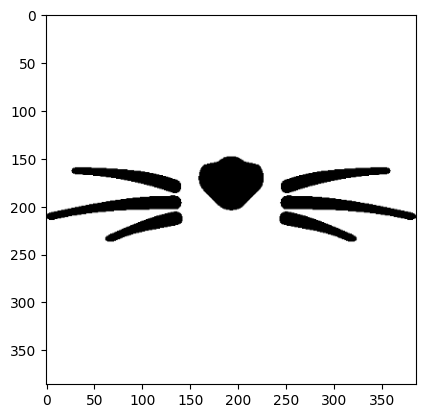

In [ ]:
plt.imshow(img_sticker)

In [ ]:
# 원본이미지에 스티커 이미지 추가하기
# x, y좌표 조정 -> 이미지 시작점은 top-left 좌표이기 때문

# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
# x는 이미지에서 코 아래의 x값 = 1792
# y는 이미지에서 코 아래의 y값 = 777
# w: 얼굴의 바운딩 박스.width = 386
# h: 얼굴의 바운딩 박스.height = 386
refined_x = x - w // 2 # 1792-(386//2) = 1792-193 = 1599
refined_y = y - h # 777-386 = 198
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작됨
print (f'(x,y) : ({refined_x},{refined_y})') # 음수 발생 : 이미지 범위를 벗어남
# 우리는 현재 이마 자리에 왕관을 두고 싶은건데, 이마위치 - 왕관 높이를 했더니 이미지의 범위를 초과하여 음수가 나오는 것
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

(x,y) : (1599,198)


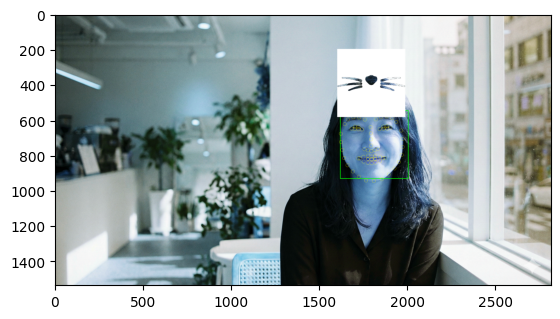

In [ ]:
# 원본 이미지에 스티커 적용하기

# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
# 예제에서는 (344,0) 부터 (344+187, 0+89) 범위의 이미지를 의미합니다.
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_show[0:0+89, 344:344+187]
# img_show[0:89, 344:531]
# 즉, x좌표는 344~531 / y좌표는 0~89가 됨
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], \
                        refined_x:refined_x+img_sticker.shape[1]]
# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()